<a href="https://colab.research.google.com/github/ollihansen90/Mathe-SH/blob/main/Schachcomputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://raw.githubusercontent.com/prateeksan/chesspi/development/sample_data/Kasparov.pgn

bauer = 1 # 1
springer = 2 # 3
laeufer = 3 # 3
turm = 4 # 5
dame = 5 # 9
koenig = 6 # 100
leer = 0
figuren = ["\u2659", "\u2659","\u2658","\u2657","\u2656","\u2655","\u2654","\u265A","\u265B","\u265C","\u265D","\u265E","\u265F"]

def flip_pos(pos):
    pos = pos[0]+str(9-int(pos[1]))
    return pos

def get_index(pos):
    pos = pos.upper()
    # erhält z. B. "D4" und gibt Liste [4,3] zurück
    assert pos[0] in "ABCDEFGH" and pos[1] in "12345678", pos+" ist keine gültige Position."

    counter = 0
    for buchstabe in "ABCDEFGH":
        if buchstabe==pos[0]:
            break
        counter += 1

    liste = [8-int(pos[1]), counter]
    return liste

class Spielfeld():
    def __init__(self):
        #self.feld = None
        self.reset()

    def reset(self):
        self.feld = [
            [-turm, -springer, -laeufer, -dame, -koenig, -laeufer, -springer, -turm],
            [-bauer, -bauer, -bauer, -bauer, -bauer, -bauer, -bauer, -bauer],
            [leer, leer, leer, leer, leer, leer, leer, leer],
            [leer, leer, leer, leer, leer, leer, leer, leer],
            [leer, leer, leer, leer, leer, leer, leer, leer],
            [leer, leer, leer, leer, leer, leer, leer, leer],
            [bauer, bauer, bauer, bauer, bauer, bauer, bauer, bauer],
            [turm, springer, laeufer, dame, koenig, laeufer, springer, turm]
        ]

    def male(self):
        output = ''
        bg = ["\x1b[47m", "\x1b[107m"]
        leer_farbe = ["\x1b[37m", "\x1b[97m"]
        counter = 0
        for reihe in self.feld:
            counter += 1
            for feld in reihe:
                if feld == 0:
                    output += bg[counter%2]+leer_farbe[counter%2]+figuren[feld]
                else:
                    output += bg[counter%2]+"\x1b[30m"+figuren[feld]
                counter += 1
            output += '\n'
        output += "\x1b[0m"
        print(output)

    def __getitem__(self, pos):
        liste = get_index(pos)
        return self.feld[liste[0]][liste[1]]

    def __setitem__(self, pos, value):
        liste = get_index(pos)
        self.feld[liste[0]][liste[1]] = value

    def flip(self):
        self.feld = self.feld[::-1]

def links(pos):
    if not pos:
        return False
    zeile = pos[1]
    spalte = pos[0]
    spalte_neu = ord(spalte)-1
    if spalte_neu>=65:
        return chr(spalte_neu)+zeile
    else:
        return False

def rechts(pos):
    if not pos:
        return False
    zeile = pos[1]
    spalte = pos[0]
    spalte_neu = ord(spalte)+1
    if spalte_neu<=72:
        return chr(spalte_neu)+zeile
    else:
        return False

def vor(pos):
    if not pos:
        return False
    zeile = pos[1]
    spalte = pos[0]
    zeile_neu = int(pos[1])+1
    if zeile_neu<=8:
        return spalte+str(zeile_neu)
    else:
        return False

def zurueck(pos):
    if not pos:
        return False
    zeile = pos[1]
    spalte = pos[0]
    zeile_neu = int(pos[1])-1
    if zeile_neu>=1:
        return spalte+str(zeile_neu)
    else:
        return False

schachbrett = Spielfeld()
schachbrett2 = Spielfeld()
schachbrett.male()

schachbrett["E2"] = leer
schachbrett["E3"] = bauer
schachbrett.male()

♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖



In [ ]:
from random import randint

def bewege_bauer(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==bauer, "Hier steht kein Bauer."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_bauer(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = bauer

def bewege_springer(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==springer, "Hier steht kein Springer."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_springer(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = springer

def bewege_turm(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==turm, "Hier steht kein Turm."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_turm(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = turm

def bewege_laeufer(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==laeufer, "Hier steht kein Läufer."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_laeufer(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = laeufer

def bewege_dame(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==dame, "Hier steht keine Dame."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_dame(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = dame

def bewege_koenig(schachbrett, pos):
    # Checkliste: Ist da Bauer? Kann er sich bewegen?
    assert abs(schachbrett[pos])==koenig, "Hier steht kein König."

    schachbrett[pos] = leer
    pos_neu = get_bewegung_koenig(schachbrett, pos)
    pos_neu = pos_neu[randint(0,len(pos_neu)-1)]
    schachbrett[pos_neu] = koenig

def get_bewegung_dame(schachbrett, pos):
    return get_bewegung_laeufer(schachbrett, pos)+get_bewegung_turm(schachbrett, pos)

def get_bewegung_koenig(schachbrett, pos):
    output = []
    figur = schachbrett[pos]
    # Springe 1 nach vorne
    pos_neu = vor(pos)
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach vorne rechts
    pos_neu = vor(rechts(pos))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach vorne links
    pos_neu = vor(links(pos))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach rechts
    pos_neu = rechts(pos)
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach hinten rechts
    pos_neu = rechts(zurueck(pos))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach hinten
    pos_neu = zurueck(pos)
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach hinten links
    pos_neu = zurueck(links(pos))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    # Springe 1 nach links
    pos_neu = links(pos)
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)

    # TODO: Rochade
    return output

def get_bewegung_bauer(schachbrett, pos):
    output = []
    figur = schachbrett[pos]
    # Springe 1 nach vorne
    pos_neu = vor(pos)
    if schachbrett[pos_neu]==leer and pos_neu:
        output.append(pos_neu)
    # Springe 2 nach vorne, falls du dich noch nicht bewegt hast
    pos_neu = vor(vor(pos))
    if pos[1]=="2" and len(output)==1 and schachbrett[pos_neu]==leer:
        output.append(pos_neu)
    # Springe 1 diagonal nach vorne, falls da ein Gegner sitzt
    # Oben rechts von B2 ist C3
    pos_neu = rechts(vor(pos))
    if pos_neu and figur*schachbrett[pos_neu]<0:
        output.append(pos_neu)
    pos_neu = links(vor(pos))
    if pos_neu and figur*schachbrett[pos_neu]<0:
        output.append(pos_neu)
    # TODO: En Passant
    return output

def get_bewegung_turm(schachbrett, pos):
    output = []
    figur = schachbrett[pos]
    # vor
    pos_neu = vor(pos)
    while pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = vor(pos_neu)

    # links
    pos_neu = links(pos)
    while pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = links(pos_neu)

    # rechts
    pos_neu = rechts(pos)
    while pos_neu and ((schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0)):
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = rechts(pos_neu)

    # zurueck
    pos_neu = zurueck(pos)
    while pos_neu and ((schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0)):
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = zurueck(pos_neu)

    # TODO: Rochade
    return output

def get_bewegung_laeufer(schachbrett, pos):
    output = []
    figur = schachbrett[pos]
    # diagonal rechts vor
    pos_neu = rechts(vor(pos))
    while pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        #print("diagonal rechts vor", pos_neu)
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = rechts(vor(pos_neu))

    # diagonal links vor
    pos_neu = vor(links(pos))
    while pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        #print("diagonal links vor",pos_neu)
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = vor(links(pos_neu))

    # diagonal links zurück
    pos_neu = links(zurueck(pos))
    while pos_neu and ((schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0)):
        #print("diagonal links zurück",pos_neu)
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = links(zurueck(pos_neu))

    # diagonal rechts zurück
    pos_neu = rechts(zurueck(pos))
    while pos_neu and ((schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0)):
        #print("diagonal rechts zurück",pos_neu)
        output.append(pos_neu)
        if figur*schachbrett[pos_neu]<0:
            break
        pos_neu = rechts(zurueck(pos_neu))

    return output

def get_bewegung_springer(schachbrett, pos):
    output = []
    figur = schachbrett[pos]
    pos_neu = rechts(vor(vor(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = links(vor(vor(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = rechts(rechts(vor(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = rechts(rechts(zurueck(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = rechts(zurueck(zurueck(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = links(zurueck(zurueck(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = links(links(zurueck(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    pos_neu = links(links(vor(pos)))
    if pos_neu and (schachbrett[pos_neu]==leer or figur*schachbrett[pos_neu]<0):
        output.append(pos_neu)
    return output

schachbrett.reset()
schachbrett["A3"] = -bauer
schachbrett["C3"] = -bauer
schachbrett["D3"] = koenig
schachbrett.male()
print(get_bewegung_koenig(schachbrett, "D3"))
bewege_koenig(schachbrett, "D3")
schachbrett.male()

♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♟♙♟♔♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

['D4', 'E4', 'C4', 'E3', 'C3']
♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♔♙♙♙♙♙
♟♙♟♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖



In [2]:
!wget https://raw.githubusercontent.com/prateeksan/chesspi/development/sample_data/Kasparov.pgn

--2024-06-19 16:32:38--  https://raw.githubusercontent.com/prateeksan/chesspi/development/sample_data/Kasparov.pgn
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1284144 (1.2M) [text/plain]
Saving to: ‘Kasparov.pgn’

Kasparov.pgn        100%[===================>]   1.22M  --.-KB/s    in 0.06s   

2024-06-19 16:32:38 (19.3 MB/s) - ‘Kasparov.pgn’ saved [1284144/1284144]



In [16]:
with open("Kasparov.txt", "rb") as file:
    zeilen = file.readlines()


In [89]:
spiele = ("\n".join([z.decode('ascii').strip() for z in zeilen[:30000]])).split("\n\n")[1::2]
print(len(spiele))

1684


In [97]:
print(len(zeilen))

spielliste = []
for spiel in spiele:
    spiel_string = ""
    for zeile in spiel:
        zeile = spiel.strip()
        if len(spiel)>0 and spiel[0]!="[":
            spiel_string += (spiel.strip()+" ")
    zugliste = [z.split(" ")[:-1] for z in (spiel_string.split("  ")[0]+" 1").split(".")[1:]]
    spielliste.append(zugliste)
print(*spielliste[0], sep="\n")

37118
['e4', 'c5']
['c3', 'Nf6']
['e5', 'Nd5']
['d4', 'Nc6']
['Nf3', 'cxd4']
['cxd4', 'e6']
['a3', 'd6']
['Bd3']
['Bd2', 'Qb6']
['Nc3', 'Nxc3']
['Bxc3', 'dxe5']
['dxe5', 'Be7']
['O-O', 'Bd7']
['Nd2', 'Qc7']
['Qg4']
['Rfc1', 'Kb8']
['Qc4', 'Rc8']
['b4', 'f6']
['Nf3', 'Qb6']
['Qe4', 'f5']
['Qe1', 'a6']
['Rab1']
['Nd2', 'Nd4']
['Qe3', 'Rxc3']
['Rxc3', 'f4']
['Qe1', 'g4']
['Ne4', 'Bc6']
['Nc5', 'Ka7']
['a4']
['a5', 'Qd8']
['Bc4', 'Bxc5']
['bxc5', 'Qh4']
['gxf3', 'gxf3']
['Kh1', 'Rg8']
['Qe4', 'Rg7']
['Qxd4']
['c6+', 'Kb8']
['c7+', 'Rxc7']
['Rg1', 'Qh5']
['Rg8+', 'Rc8']
['Qd6+', 'Ka7']


In [98]:

print(*spielliste[10], sep="\n")

['e4', 'c6']
['d4', 'd5']
['Nd2', 'dxe4']
['Nxe4', 'Bf5']
['Ng3', 'Bg6']
['h4', 'h6']
['Nf3', 'Nd7']
['h5']
['Bd3', 'Bxd3']
['Qxd3', 'Qc7']
['Rh4', 'e6']
['Bf4', 'Qa5+']
['Bd2', 'Qc7']
['Bf4', 'Qa5+']


[[0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0.]]


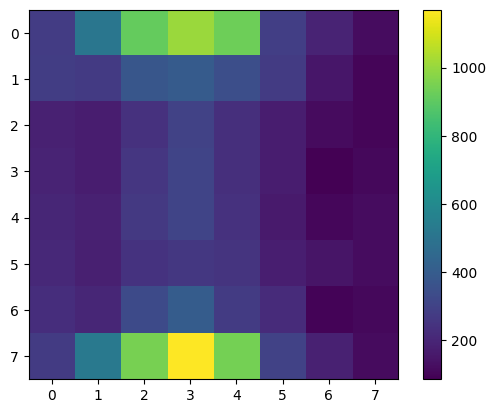

In [104]:
import numpy as np
import matplotlib.pyplot as plt

feld = np.zeros([8,8])
pos = get_index("B1")
feld[pos[0], pos[1]] += 1
pos = get_index("G1")
feld[pos[0], pos[1]] += 1
pos = get_index("B8")
feld[pos[0], pos[1]] += 1
pos = get_index("G8")
feld[pos[0], pos[1]] += 1

print(feld)
for zugliste in spielliste:
    for zug in zugliste:
        for z in zug:
            z = z.replace("+", "")
            if z[0]=="R":
                pos = get_index(z[-2:])
                feld[pos[0], pos[1]] += 1

plt.figure()
plt.imshow(feld)
plt.colorbar()
plt.show()
